# Сборный проект — 2

 ## Описание проекта

 Позади много уроков и заданий, и закрепить свои знания, как обычно, вы сможете в самостоятельном проекте. Это непростой проект, в котором от вас потребуется больше самостоятельности. Этапы работы описаны кратко, и вам понадобится декомпозировать задачи, то есть разделить их на более мелкие. Опирайтесь на знания об этапах анализа данных и машинного обучения из прошлых курсов.

 Перейдём к задаче. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

 Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

 Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

 У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
 
 Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

 Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Цель исследования

 Цель исследования — разработать модель машинного обучения, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика и предсказать то, что сотрудник уволится из компании.

## Ход исследования:

   1. Сбор и предварительная обработка данных.
   2. Исследовательский анализ данных.
   3. Подготовка данных.
   4. Обучение моделей.
   5. Общий вывод.


## Задача 1: предсказание уровня удовлетворённости сотрудника

 Для этой задачи заказчик предоставил данные с признаками:
 - id — уникальный идентификатор сотрудника;
 - dept — отдел, в котором работает сотрудник;
 - level — уровень занимаемой должности;
 - workload — уровень загруженности сотрудника;
 - employment_years — длительность работы в компании (в годах);
 - last_year_promo — показывает, было ли повышение за последний год;
 - last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
 - supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
 - salary — ежемесячная зарплата сотрудника;
 - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
# #установка модулей
# !pip install -Uq scikit-learn
# !pip install catboost
# !pip install phik
# !pip install shap

In [2]:
# импорт библиотеки
import pandas as pd
import numpy as np
import catboost

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,make_scorer,r2_score

import shap

from phik.report import plot_correlation_matrix
from phik import report

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment=None

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Шаг 1. Загрузка данных

### Загрузите файлы с данными

In [4]:
train_job_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
test_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [5]:
train_job_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
train_job_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
test_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [9]:
test_target_df.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [10]:
test_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


<b>Вывод</b>

- Данные соответствуют по описанию задачи.
- В датасетах есть  количественные и категориальные признаки.

## Шаг 2. Предобработка данных

### Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [11]:
#количество пропущенных значений
train_job_df.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [12]:
#количество пропущенных значений
test_df.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [13]:
#количество пропущенных значений
test_target_df.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [14]:
print('подсчёт явных дубликатов train_job_df:',train_job_df.duplicated().sum())
print('подсчёт явных дубликатов test_df:',test_df.duplicated().sum())


подсчёт явных дубликатов train_job_df: 0
подсчёт явных дубликатов test_df: 0


In [15]:
print('подсчёт полных дубликатов train_job_df:',train_job_df.drop(['id'],axis=1).duplicated().sum())
print('подсчёт полных дубликатов test_df:',test_df.drop(['id'],axis=1).duplicated().sum())


подсчёт полных дубликатов train_job_df: 245
подсчёт полных дубликатов test_df: 557


In [16]:
# Уникальные значения по категориальным значениям train_job_df
cat_col=train_job_df.select_dtypes(include=['object'])
for column in cat_col:
    print(column)
    print(train_job_df[column].unique())
    print()

dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

level
['junior' 'middle' 'sinior' nan]

workload
['medium' 'high' 'low']

last_year_promo
['no' 'yes']

last_year_violations
['no' 'yes']



In [17]:
# Уникальные значения по категориальным значениям test_df
cat_col=test_df.select_dtypes(include=['object'])
for column in cat_col:
    print(column)
    print(test_df[column].unique())
    print()

dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

level
['junior' 'middle' 'sinior' nan]

workload
['medium' 'low' 'high' ' ']

last_year_promo
['no' 'yes']

last_year_violations
['no' 'yes']



<b>Вывод</b>

В ходе предобработки данных:

- Проверена наличие пропущенных значений  их заполним в пайплайн.
- Явные  дубликаты нет.
- Удалим полные дубликаты после анализ данных.

## Шаг 3. Исследовательский анализ данных

### Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.

In [18]:
# Cтатистический анализ для числовых признаков train_job_df
train_job_df.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [19]:
# Cтатистический анализ для категориальных признаков train_job_df
train_job_df.describe(include=['object'])

,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


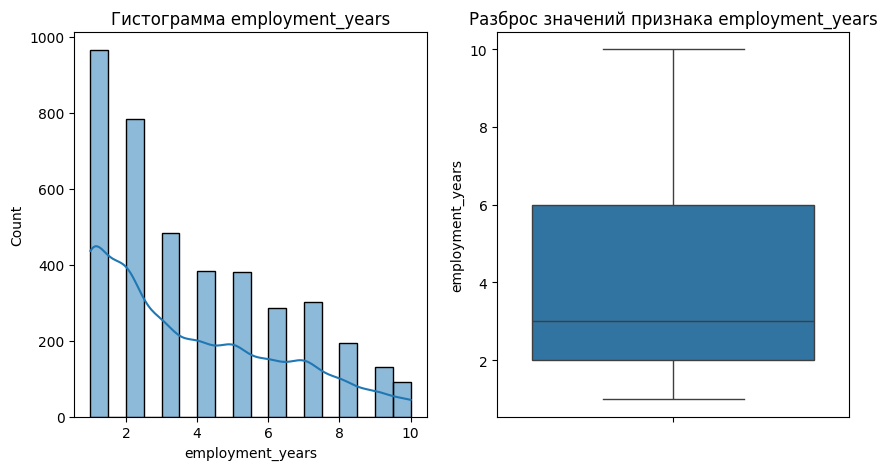

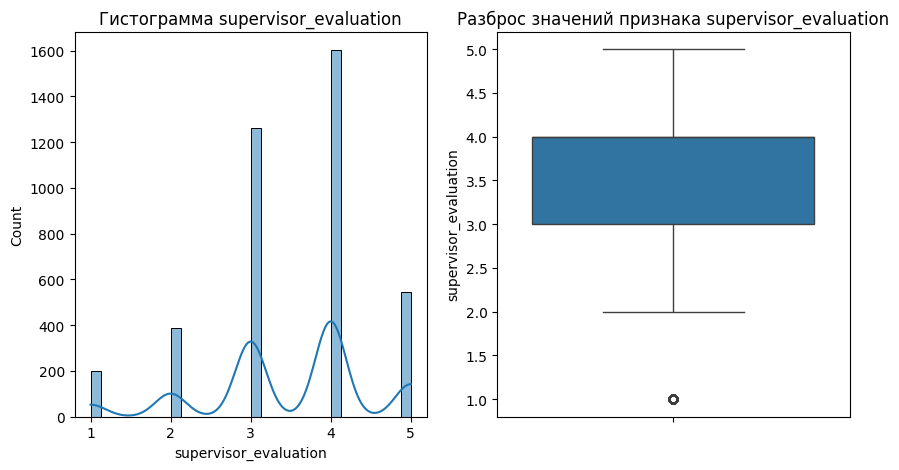

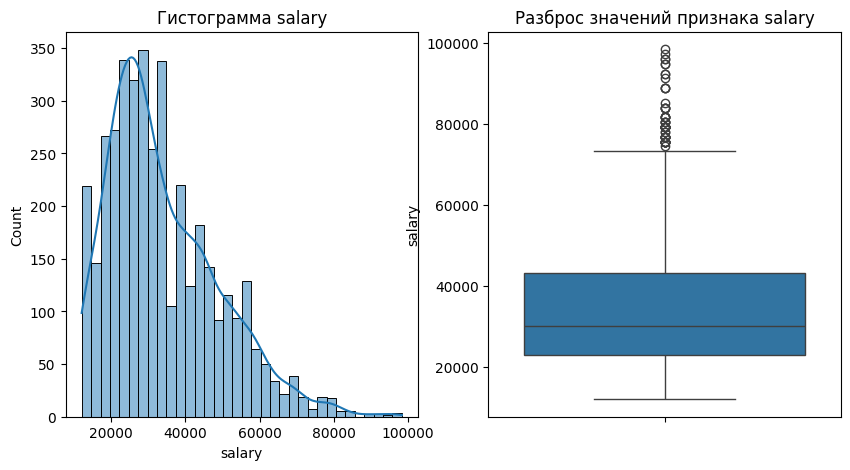

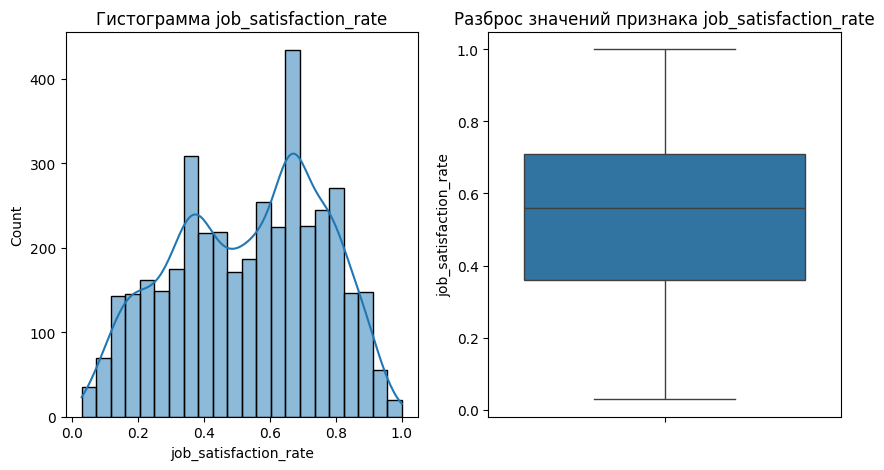

In [20]:
# построим графики по количественным признакам train_job_df датасета
# гистограмму частотности распределения и ящик с усами. 
num_col=train_job_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=train_job_df.select_dtypes(include=['object']).columns.to_list()

for n_col in num_col[1:]:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(train_job_df[n_col], kde=True)
        plt.title(f'Гистограмма {n_col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=train_job_df[n_col])
        plt.title(f'Разброс значений признака {n_col}')
        plt.show()

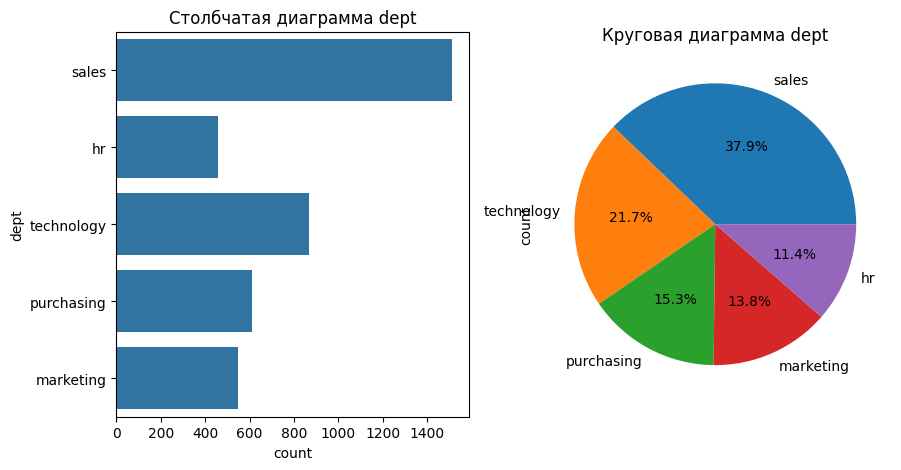

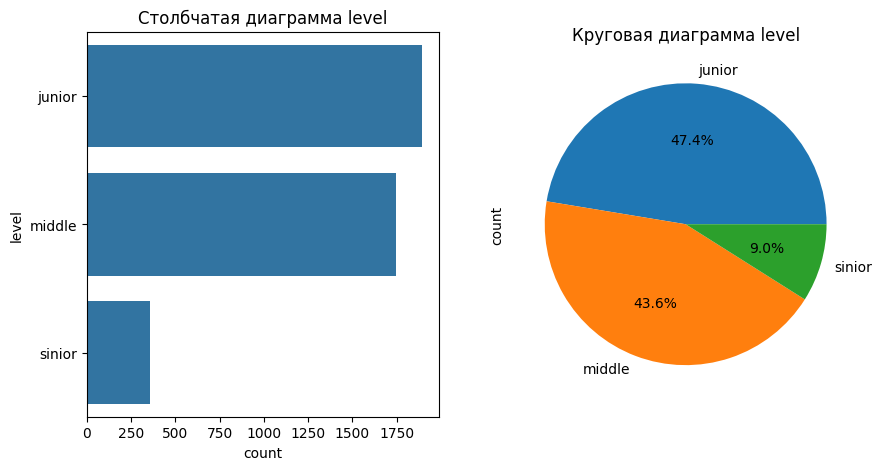

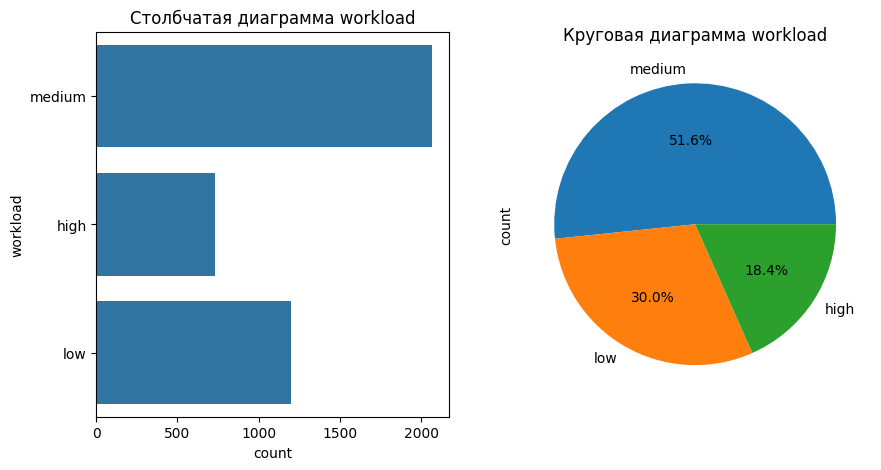

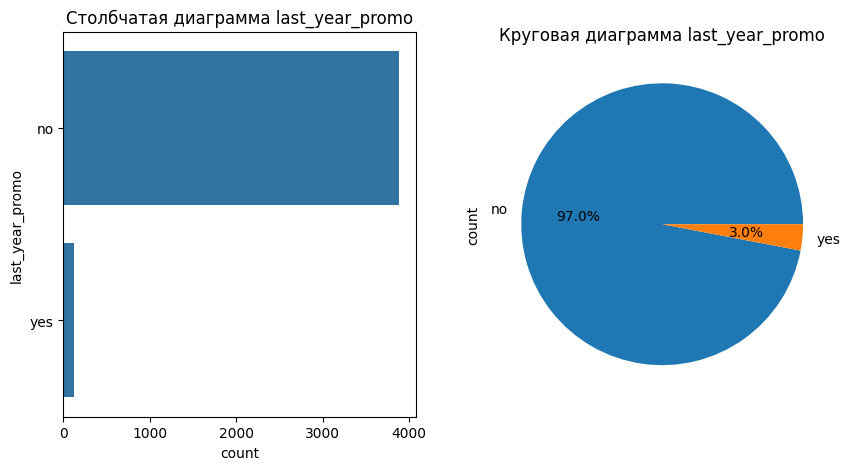

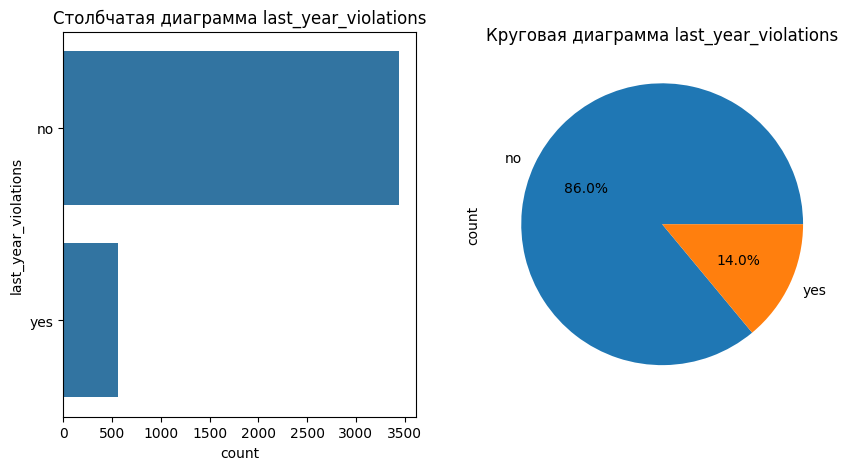

In [21]:
# построим графики по категориальним признакам train_job_df датасета
# столбчатая и круговая диаграмма. 

num_col=train_job_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=train_job_df.select_dtypes(include=['object']).columns.to_list()

for c_col in cat_col:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.countplot(y=train_job_df[c_col])
        plt.title(f'Столбчатая диаграмма {c_col}')
        
        plt.subplot(1, 2, 2)
        train_job_df[c_col].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(f'Круговая диаграмма {c_col}')
        plt.show()

In [22]:
# Обьединим test_df и test_target df
test_full_df=pd.merge(test_df,test_target_df,on='id',how='left')

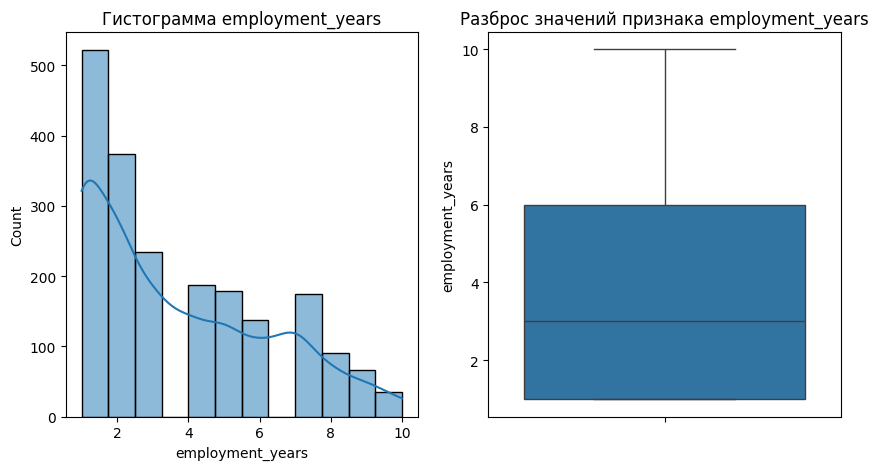

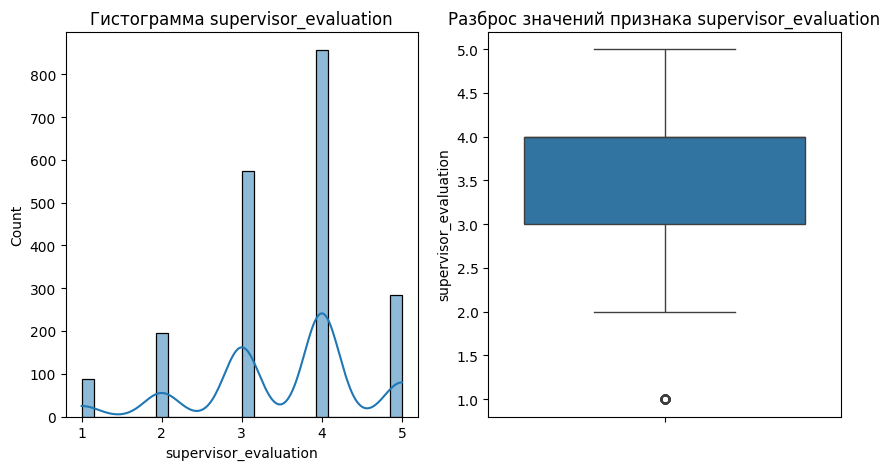

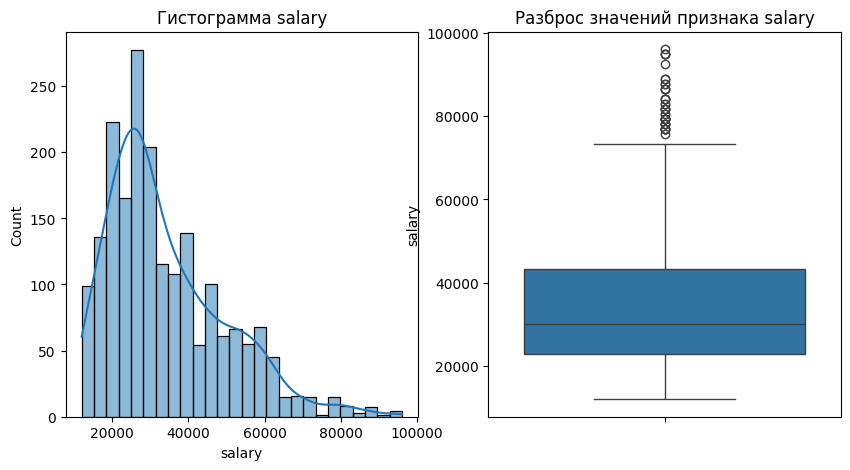

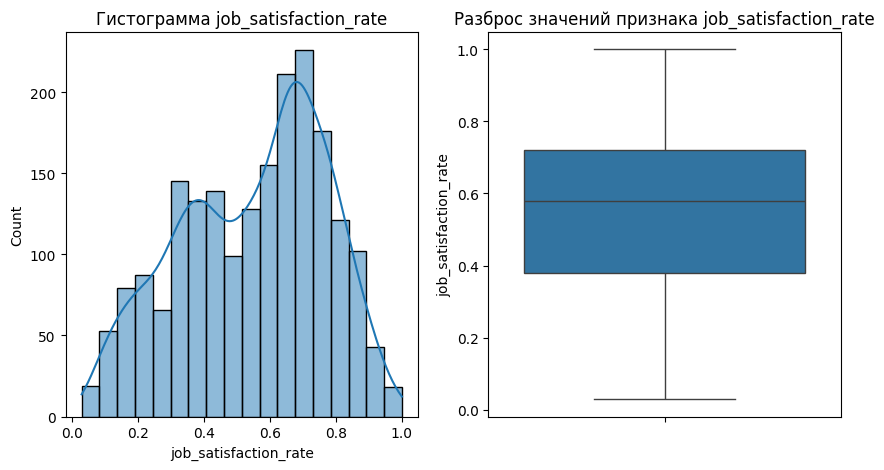

In [23]:
# построим графики по количественным признакам test_full_df датасета
# гистограмму частотности распределения и ящик с усами. 
num_col=test_full_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=test_full_df.select_dtypes(include=['object']).columns.to_list()

for n_col in num_col[1:]:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(test_full_df[n_col], kde=True)
        plt.title(f'Гистограмма {n_col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=test_full_df[n_col])
        plt.title(f'Разброс значений признака {n_col}')
        plt.show()

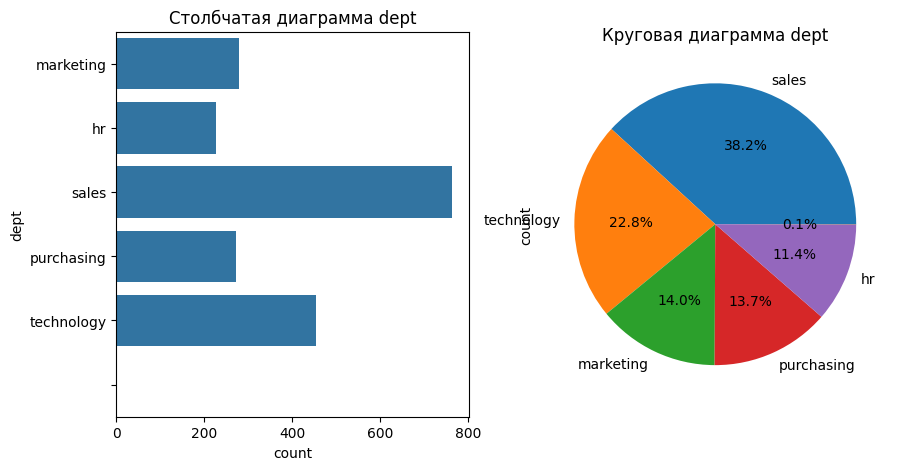

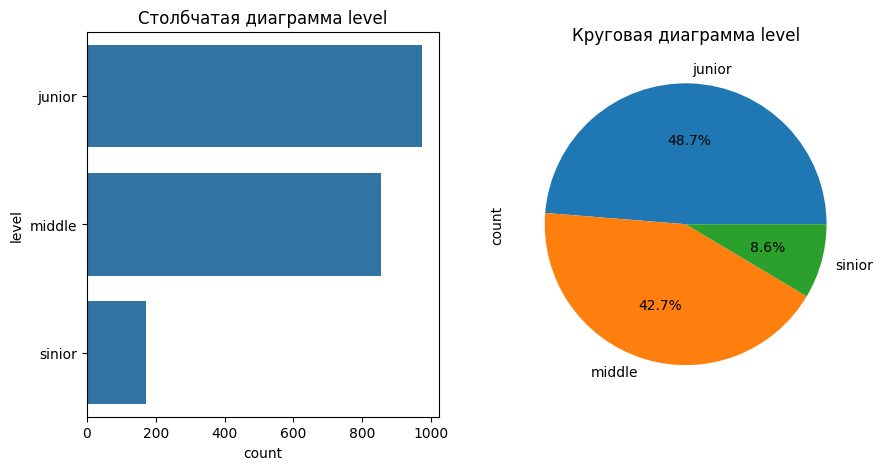

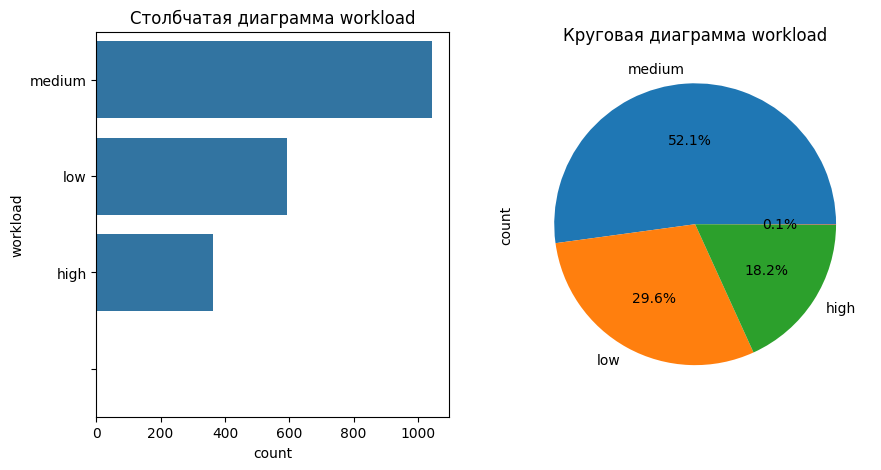

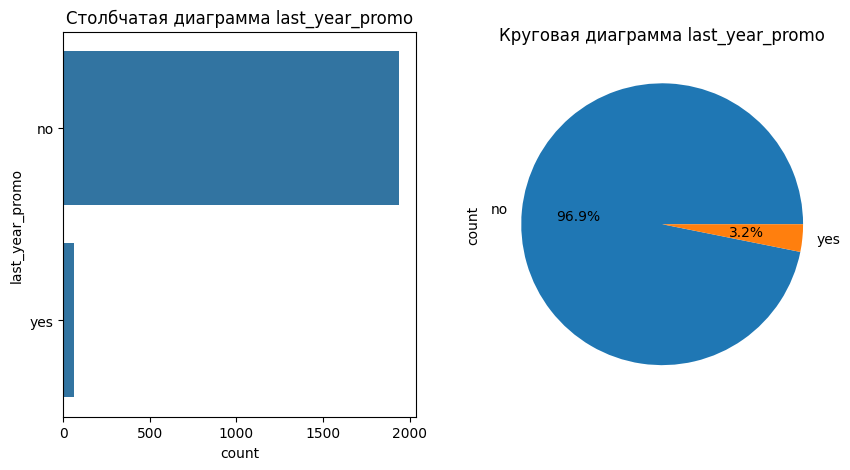

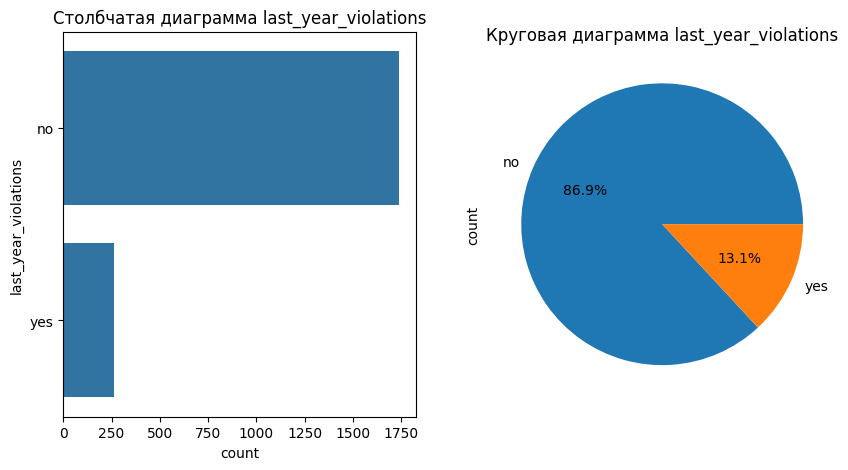

In [24]:
# построим графики по категориальним признакам test_full_df датасета
# столбчатая и круговая диаграмма. 

num_col=test_full_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=test_full_df.select_dtypes(include=['object']).columns.to_list()

for c_col in cat_col:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.countplot(y=test_full_df[c_col])
        plt.title(f'Столбчатая диаграмма {c_col}')
        
        plt.subplot(1, 2, 2)
        test_full_df[c_col].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(f'Круговая диаграмма {c_col}')
        plt.show()

Корреляционный анализ

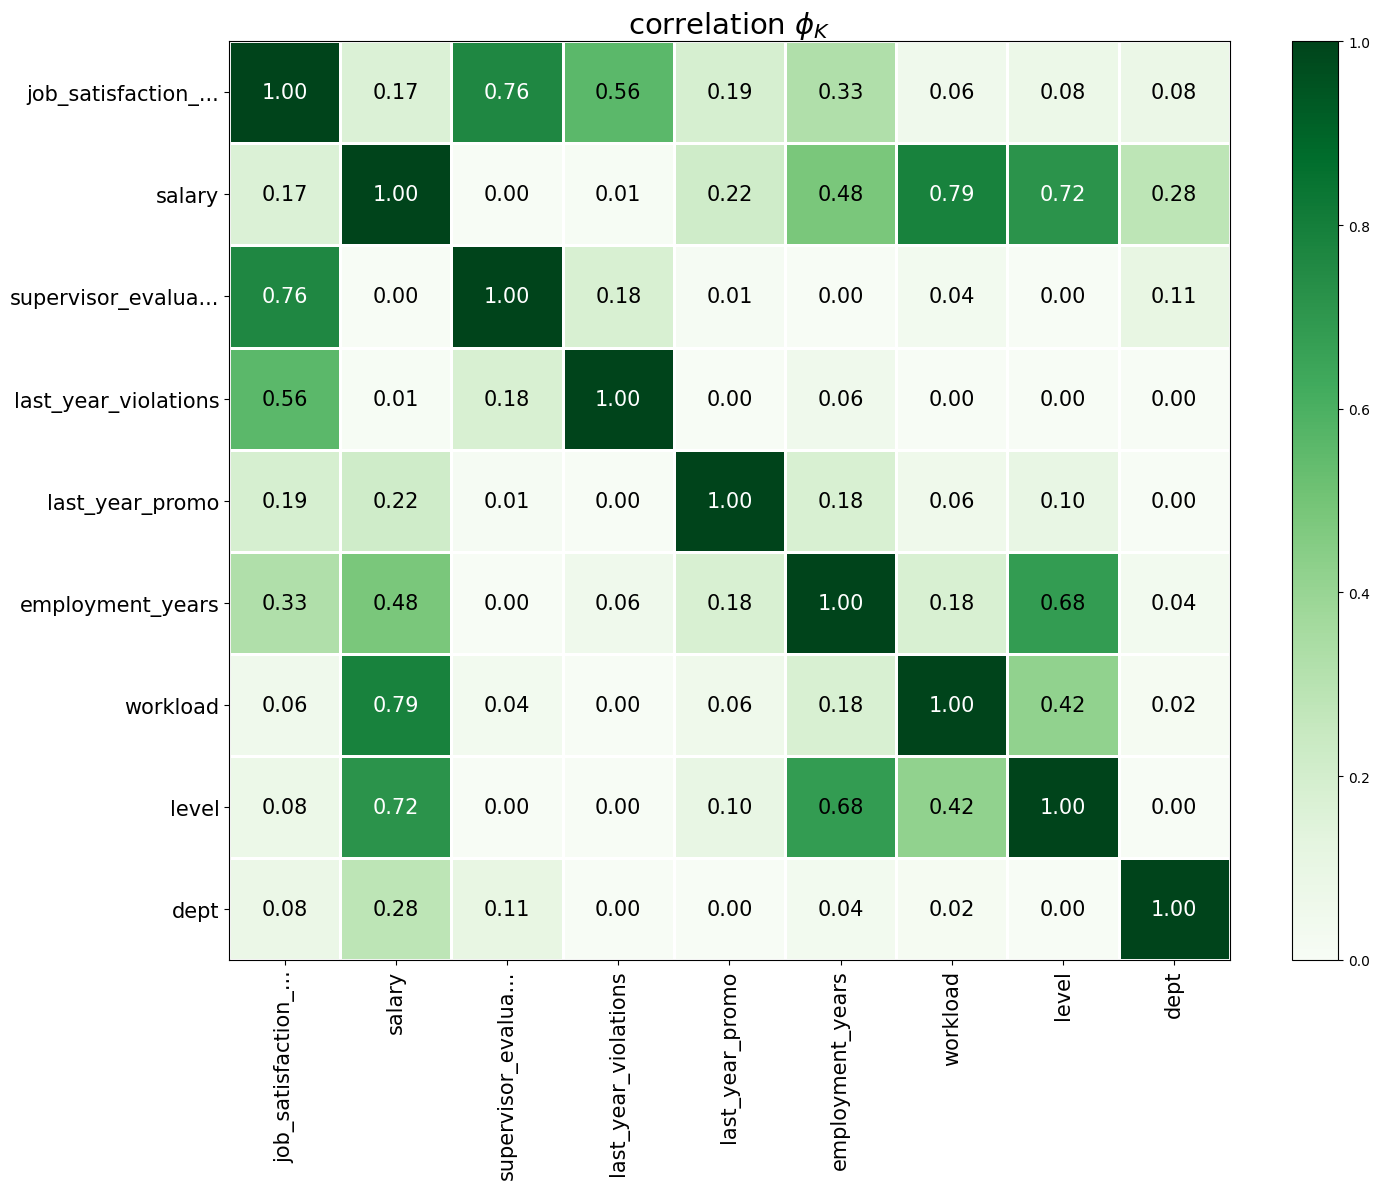

In [25]:
# список интервальных признаков
train_df=train_job_df.drop(['id'],axis=1)
interval_cols = train_df.select_dtypes(include=['number']).columns.to_list()


# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = train_df.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

<b>Вывод</b>

- Распределния признака salary похоже на распределения Пуассона.
- Доля признака нарушения больше чем признака повышения за последний год.
- В основном работники  джуниор и мидл.
- Большая часть сотрудники в отделе sales.
- Наблюдается высокое корреляционное значения.
- Для признака workload,level используем кодировку ordinalencoder.
- Для признака dept,last_year_promo, last_year_violations используем кодировку OneHotEncoder.

## Шаг 4. Подготовка данных

### Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки. При кодировании учитывайте особенности  признаков и моделей и используйте как минимум два кодировщика.

In [26]:
#Удалим полные дубликаты перед подоготовка

# train_job_df.drop_duplicates(train_job_df.drop('id', axis=1).columns,keep='first',inplace=True)

In [27]:
train_job_df.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [28]:
X_train=train_job_df.drop(['id','job_satisfaction_rate'], axis=1)
y_train=train_job_df['job_satisfaction_rate']



ohe_columns = ['dept','last_year_promo', 'last_year_violations']
ord_columns = ['workload','level']
num_columns = ['employment_years','supervisor_evaluation','salary']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

## Шаг 5. Обучение моделей

### Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.

### Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

In [29]:
#функция SMAPE
def smape_score(y_true,y_pred):
    y_true=np.array(y_true)
    y_pred=np.array(y_pred)
    sm = 2 * np.abs(y_true-y_pred) / (np.abs(y_true)+np.abs(y_pred))
    return np.sum(sm) / len(sm) * 100

In [30]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели RandomForestRegressor() 
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 40),
        'models__n_estimators': range(100, 500),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]    
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True,False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    # словарь для модели CatBoostRegressor()
    {
        'models': [catboost.CatBoostRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__iterations': range(100, 1000),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    }
]

smape_scorer = make_scorer(
    smape_score,
    greater_is_better=False
) 

scoring = {
    'r2_score': 'r2',
    'smape_score': smape_scorer
} 

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scoring,
    refit='smape_score',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

Learning rate set to 0.134915
0:	learn: 0.2041871	total: 155ms	remaining: 46.6s
1:	learn: 0.1871471	total: 159ms	remaining: 23.9s
2:	learn: 0.1721328	total: 162ms	remaining: 16.1s
3:	learn: 0.1595779	total: 175ms	remaining: 13.1s
4:	learn: 0.1468154	total: 183ms	remaining: 10.9s
5:	learn: 0.1374061	total: 188ms	remaining: 9.25s
6:	learn: 0.1288215	total: 218ms	remaining: 9.21s
7:	learn: 0.1218544	total: 229ms	remaining: 8.4s
8:	learn: 0.1151815	total: 235ms	remaining: 7.65s
9:	learn: 0.1097815	total: 241ms	remaining: 7.02s
10:	learn: 0.1065889	total: 246ms	remaining: 6.5s
11:	learn: 0.1043171	total: 248ms	remaining: 5.98s
12:	learn: 0.1011051	total: 253ms	remaining: 5.61s
13:	learn: 0.0981886	total: 261ms	remaining: 5.37s
14:	learn: 0.0959061	total: 269ms	remaining: 5.15s
15:	learn: 0.0929775	total: 278ms	remaining: 4.96s
16:	learn: 0.0922128	total: 280ms	remaining: 4.69s
17:	learn: 0.0892063	total: 285ms	remaining: 4.5s
18:	learn: 0.0870454	total: 290ms	remaining: 4.32s
19:	learn: 0.0

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                               MinMaxScaler()]},
                                        {'models': [<catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>],
                                         'models__iterations': range(100, 1000),
                                         'models__max_depth': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, refit='smape_score',
                   scoring={'r2_score': 'r2',
                            'smape_score': make_scorer(smape_score, greater_is_better=False, response_method='predict')})

In [31]:
# Получаем топ-10 лучших моделей, для анализа
pd.set_option('display.max_colwidth', None)
rs_top_10 = pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_smape_score', ascending=True).head(10)
rs_top_10[['mean_test_r2_score','param_models','params','mean_test_smape_score','rank_test_smape_score']]

,mean_test_r2_score,param_models,params,mean_test_smape_score,rank_test_smape_score
3,0.934173,<catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 9, 'models__iterations': 302, 'models': <catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>}",-11.144509,1
4,0.928791,<catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 11, 'models__iterations': 980, 'models': <catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>}",-11.572249,2
0,0.916379,<catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 15, 'models__iterations': 809, 'models': <catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>}",-12.502877,3
8,0.917173,<catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 3, 'models__iterations': 767, 'models': <catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>}",-12.519974,4
1,0.903259,RandomForestRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 163, 'models__max_depth': 21, 'models': RandomForestRegressor(random_state=42)}",-13.249552,5
7,0.903501,RandomForestRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 308, 'models__max_depth': 15, 'models': RandomForestRegressor(random_state=42)}",-13.250288,6
6,0.886688,<catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 2, 'models__iterations': 485, 'models': <catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>}",-14.287806,7
9,0.879156,RandomForestRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 198, 'models__max_depth': 9, 'models': RandomForestRegressor(random_state=42)}",-14.882448,8
2,0.689079,RandomForestRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 296, 'models__max_depth': 2, 'models': RandomForestRegressor(random_state=42)}",-23.505729,9
5,NaN,<catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>,"{'preprocessor__num': MinMaxScaler(), 'models__max_depth': 19, 'models__iterations': 751, 'models': <catboost.core.CatBoostRegressor object at 0x000002FA85F1BF10>}",NaN,10


In [32]:
X_test=test_full_df.drop(['id','job_satisfaction_rate'],axis=1)
y_test=test_full_df['job_satisfaction_rate']
y_pred = randomized_search.predict(X_test)
print('Метрика SMAPE:', smape_score(y_test, y_pred))

Метрика SMAPE: 10.542835329952121


In [33]:
print('Лучшая модель и её параметры:',randomized_search.best_estimator_.named_steps['models'].get_params())

Лучшая модель и её параметры: {'loss_function': 'RMSE', 'random_state': 42, 'max_depth': 9, 'iterations': 302}


<b>Вывод</b>

- Критерий успеха выполнено smape_score=10.6 < 15.

## Шаг 6. Оформление выводов

### Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.

<b>Вывод</b>

- Лучшая модель CatBoostRegressor с параметрамы {'loss_function': 'RMSE', 'random_state': 42, 'max_depth': 9, 'iterations': 302}  метрика на тесте smape_score=10.6.

- CatBoost устойчива к переобучению.

- CatBoost использует продвинутые методы градиентного бустинга, такие как алгоритм построения деревьев с симметричной структурой и оптимизация градиентов, что делает его более точным и эффективным в сравнении с другими бустинг-методами.



## Задача 2: предсказание увольнения сотрудника из компании

 ### Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

## Шаг 1. Загрузка данных

 ### Загрузите данные из файлов:

In [34]:

train_quit_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_quit_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [35]:
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [36]:
train_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [37]:
test_quit_df.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [38]:
test_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


## Шаг 2. Предобработка данных 

 ### Изучите данные и при необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [39]:
#количество пропущенных значений
train_quit_df.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [40]:
print('подсчёт явных дубликатов train_quit_df:',train_quit_df.duplicated().sum())

подсчёт явных дубликатов train_quit_df: 0


In [41]:
print('подсчёт полных дубликатов train_quit_df:',train_quit_df.drop(['id'],axis=1).duplicated().sum())

подсчёт полных дубликатов train_quit_df: 1413


In [42]:
# Уникальные значения по категориальным значениям train_quit_df
cat_col=train_quit_df.select_dtypes(include=['object'])
for column in cat_col:
    print(column)
    print(train_quit_df[column].unique())
    print()

dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']

level
['middle' 'junior' 'sinior']

workload
['high' 'medium' 'low']

last_year_promo
['no' 'yes']

last_year_violations
['no' 'yes']

quit
['no' 'yes']



<b>Вывод</b>

В ходе предобработки данных:

- Явные  дубликаты нет.
- Удалим полные дубликаты после анализ данных.

## Шаг 3. Исследовательский анализ данных

 ### 3.1. Проведите исследовательский анализ данных.

In [43]:
# Cтатистический анализ для числовых признаков train_quit_df
train_quit_df.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [44]:
# Cтатистический анализ для категориальных признаков train_quit_df
train_quit_df.describe(include=['object'])

,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872


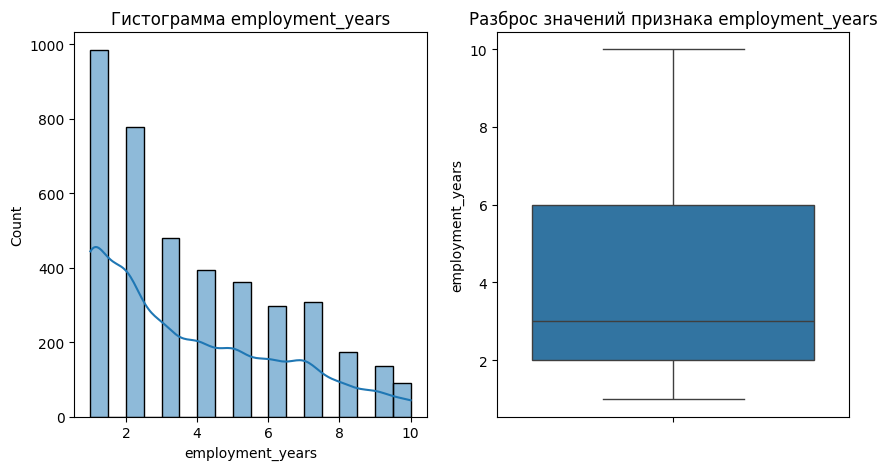

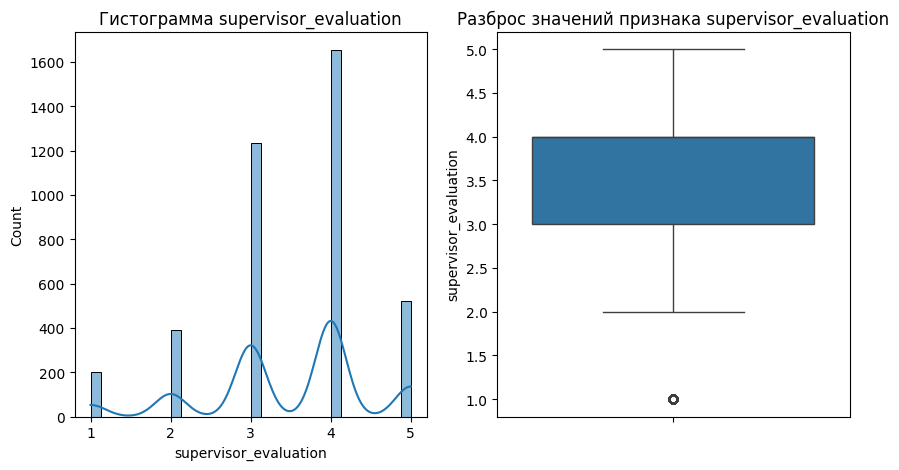

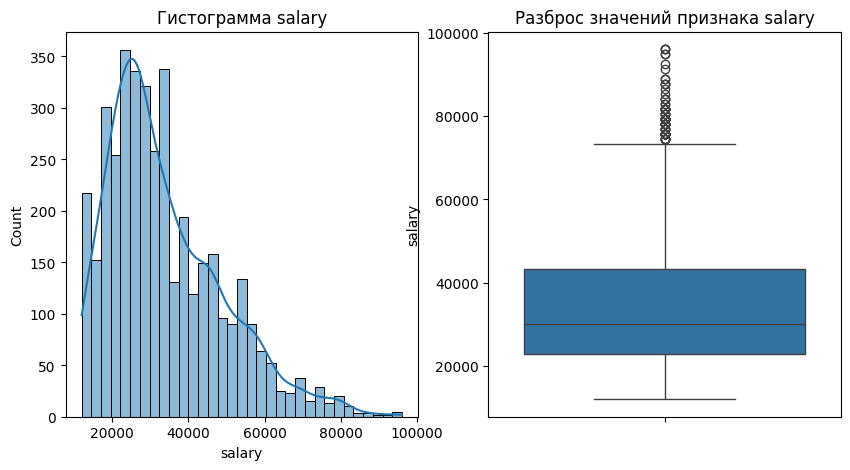

In [45]:
# построим графики по количественным признакам train_quit_df датасета
# гистограмму частотности распределения и ящик с усами. 
num_col=train_quit_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=train_quit_df.select_dtypes(include=['object']).columns.to_list()

for n_col in num_col[1:]:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(train_quit_df[n_col], kde=True)
        plt.title(f'Гистограмма {n_col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=train_quit_df[n_col])
        plt.title(f'Разброс значений признака {n_col}')
        plt.show()

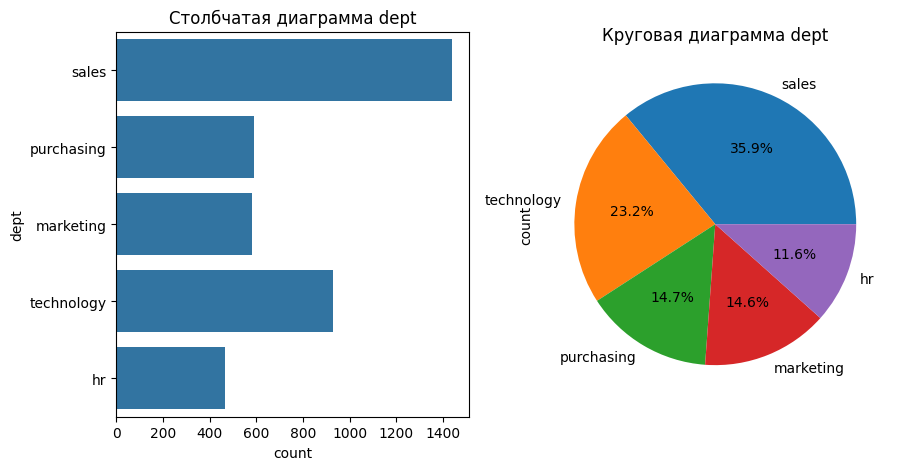

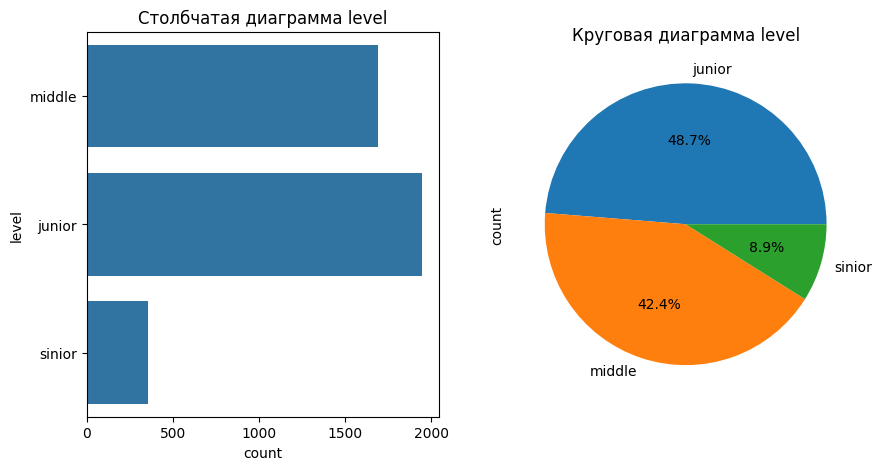

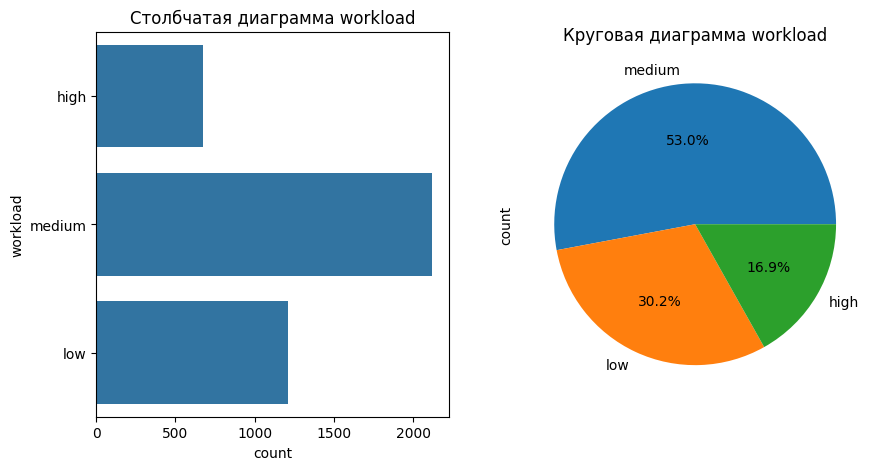

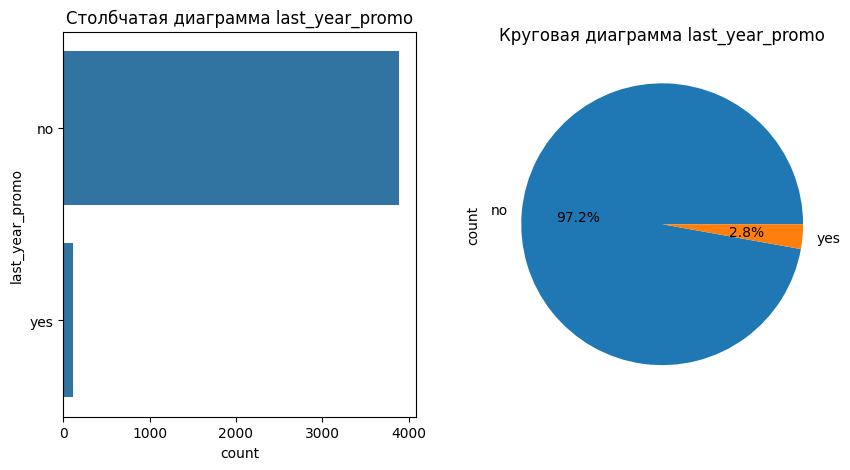

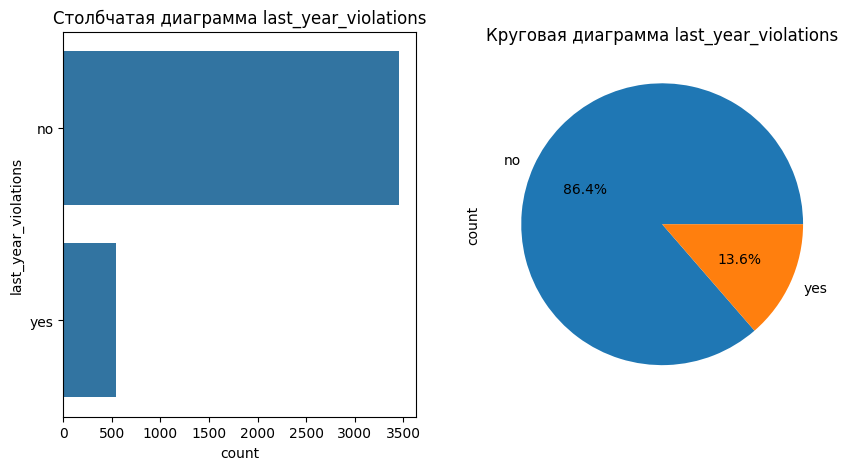

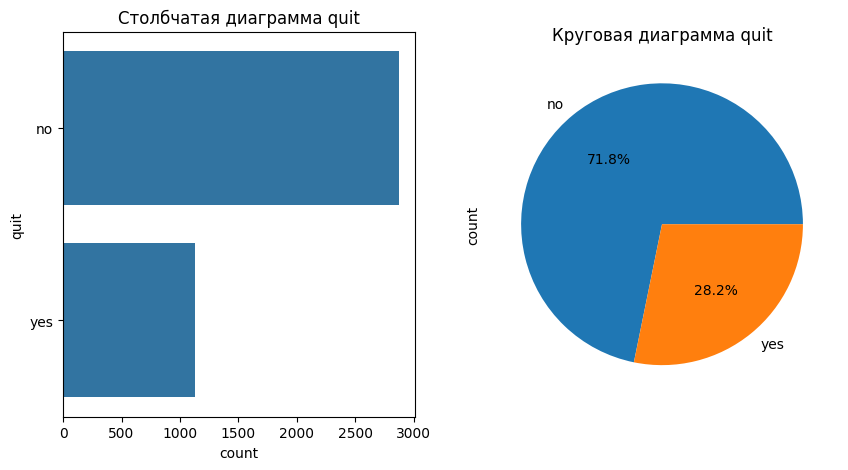

In [46]:
# построим графики по категориальним признакам train_quit_df датасета
# столбчатая и круговая диаграмма. 

num_col=train_quit_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=train_quit_df.select_dtypes(include=['object']).columns.to_list()

for c_col in cat_col:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.countplot(y=train_quit_df[c_col])
        plt.title(f'Столбчатая диаграмма {c_col}')
        
        plt.subplot(1, 2, 2)
        train_quit_df[c_col].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(f'Круговая диаграмма {c_col}')
        plt.show()

In [47]:
# Обьединим test_df и test_quit_df
test_full_quit_df=pd.merge(test_df,test_quit_df,on='id',how='left')

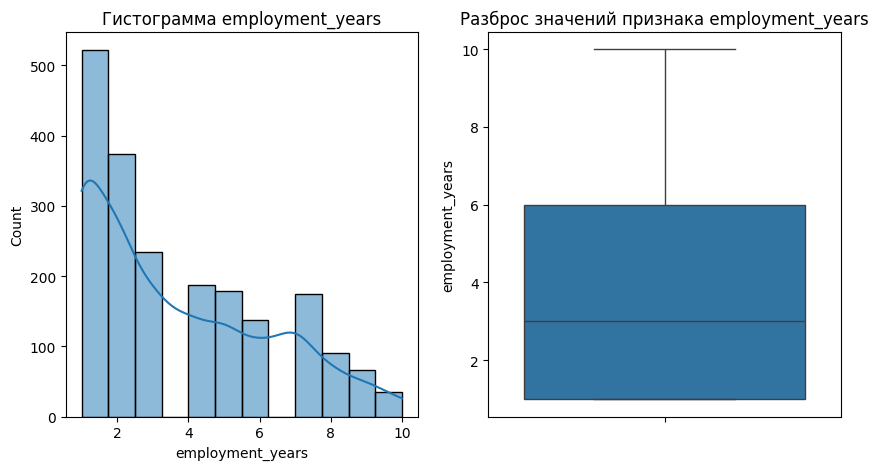

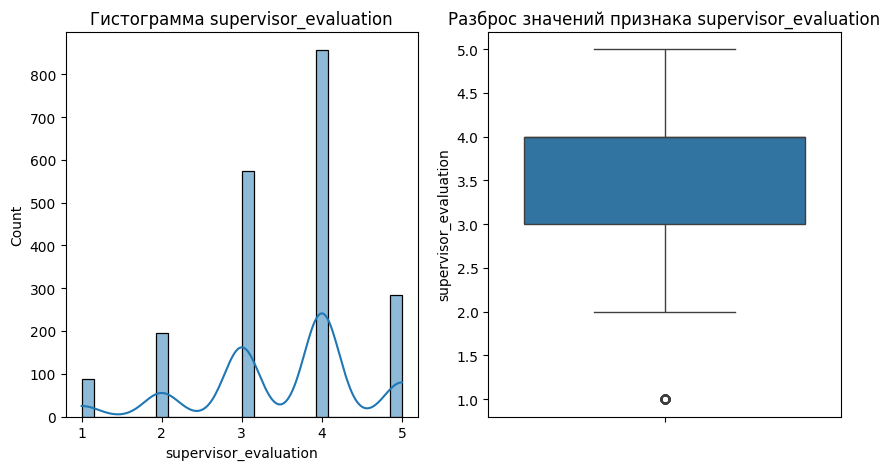

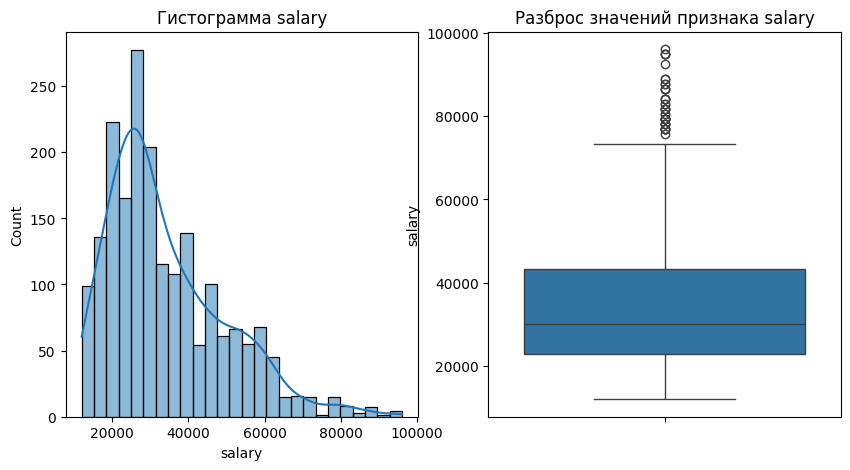

In [48]:
# построим графики по количественным признакам test_full_quit_df датасета
# гистограмму частотности распределения и ящик с усами. 
num_col=test_full_quit_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=test_full_quit_df.select_dtypes(include=['object']).columns.to_list()

for n_col in num_col[1:]:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(test_full_quit_df[n_col], kde=True)
        plt.title(f'Гистограмма {n_col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=test_full_quit_df[n_col])
        plt.title(f'Разброс значений признака {n_col}')
        plt.show()

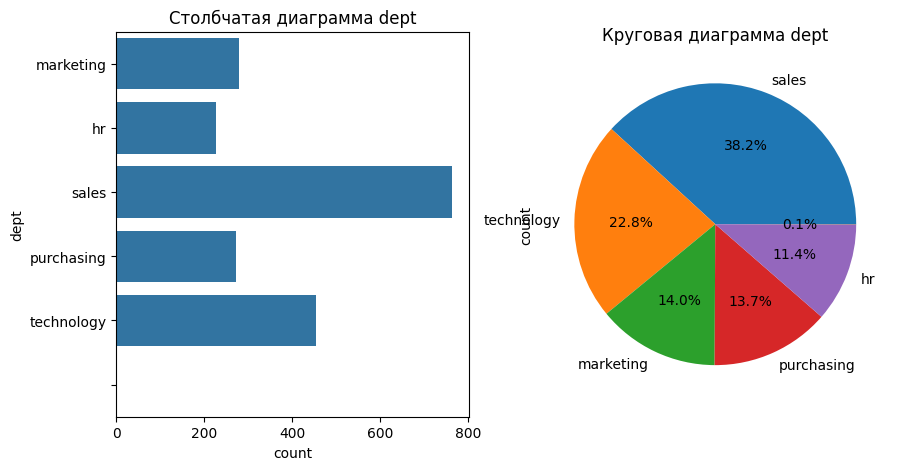

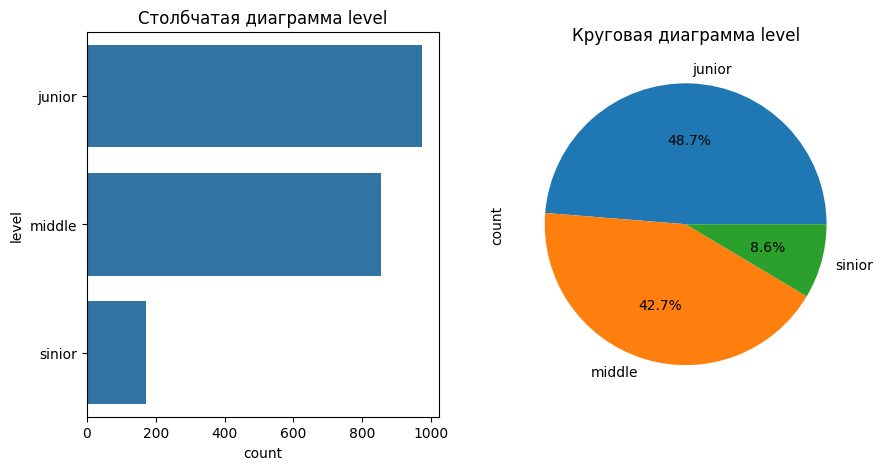

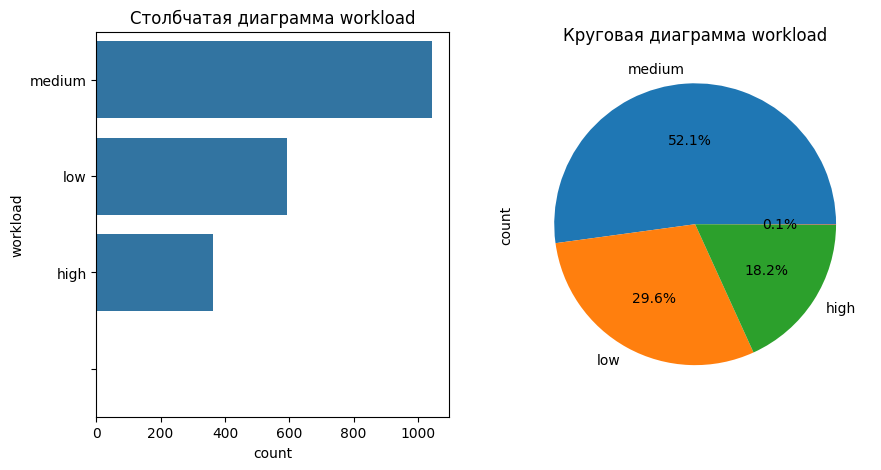

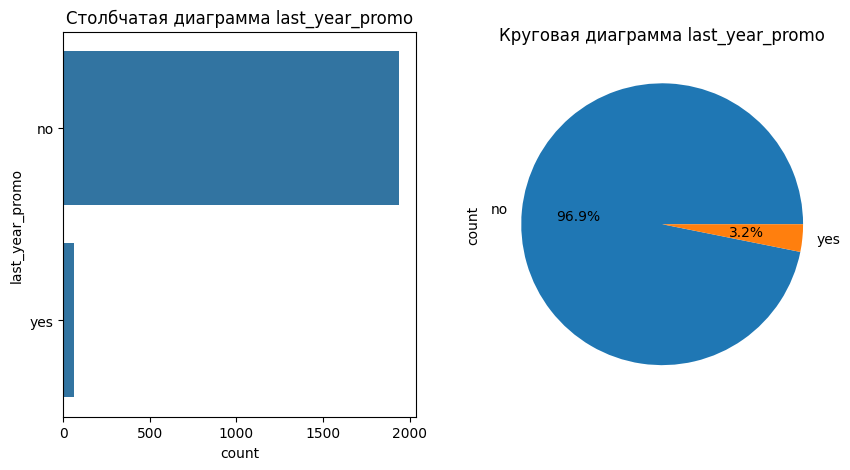

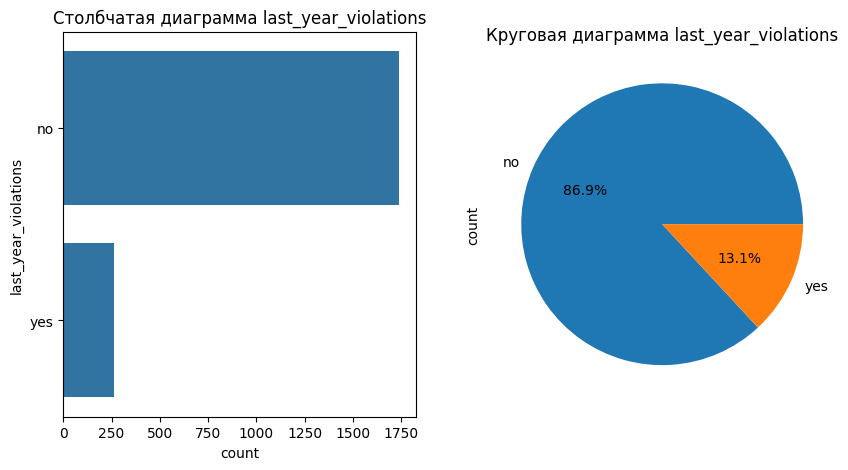

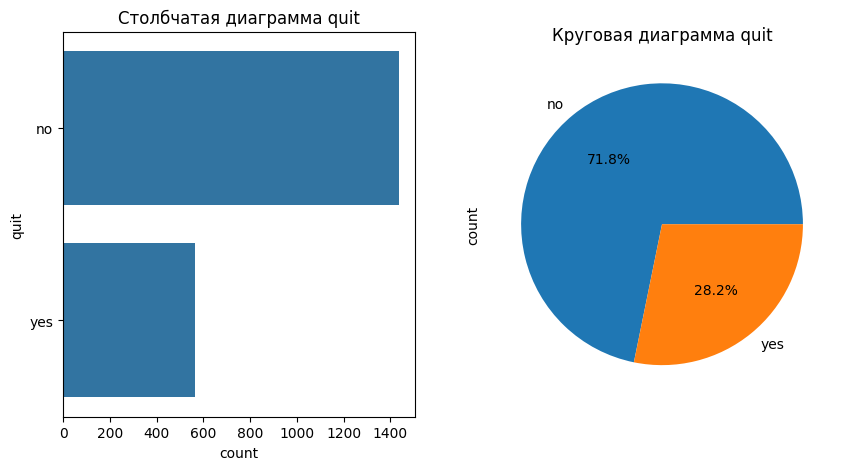

In [49]:
# построим графики по категориальним признакам test_full_quit_df датасета
# столбчатая и круговая диаграмма. 

num_col=test_full_quit_df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=test_full_quit_df.select_dtypes(include=['object']).columns.to_list()

for c_col in cat_col:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.countplot(y=test_full_quit_df[c_col])
        plt.title(f'Столбчатая диаграмма {c_col}')
        
        plt.subplot(1, 2, 2)
        test_full_quit_df[c_col].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(f'Круговая диаграмма {c_col}')
        plt.show()


<b>Вывод</b>

- Распределния признака salary похоже на распределения Пуассона.
- Доля признака нарушения больше чем признака повышения за последний год.
- В основном работники  джуниор и мидл.
- Большая часть сотрудники в отделе sales.

### 3.2. Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

In [50]:
train_quit_df['quit']=np.where(train_quit_df['quit']=='yes',1,0)
test_full_quit_df['quit']=np.where(test_full_quit_df['quit']=='yes',1,0)

In [51]:
quit_train=train_quit_df[train_quit_df['quit']==1]

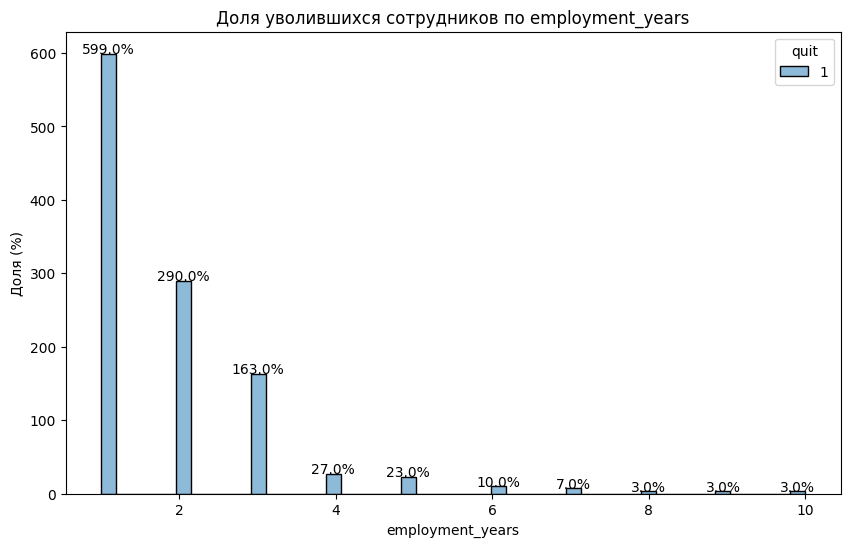

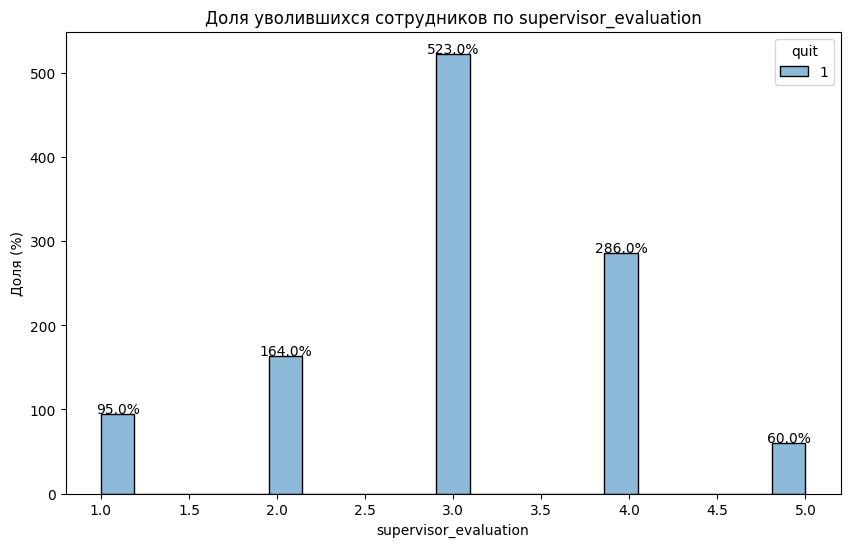

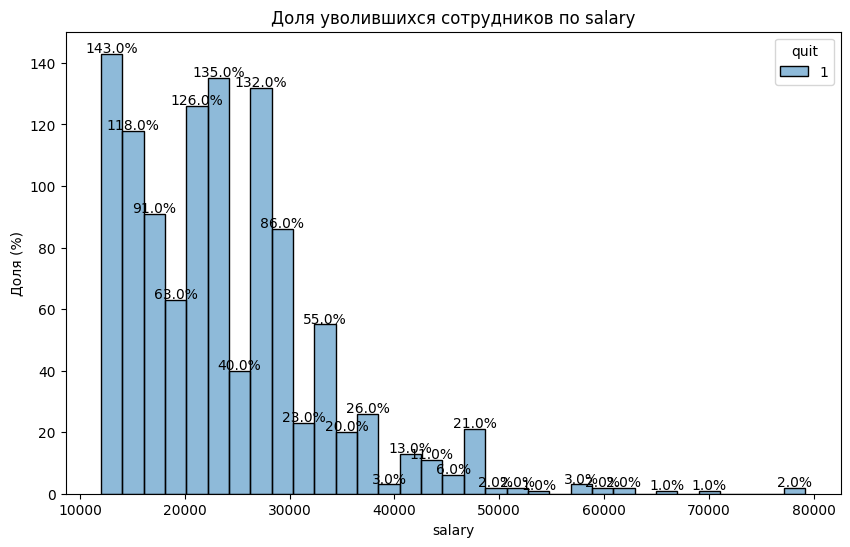

In [52]:
num_col=quit_train.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col=quit_train.select_dtypes(include=['object']).columns.to_list()
for n_col in num_col[1:]:
    plt.figure(figsize=(10, 6))
    ax=sns.histplot(data=quit_train, x=n_col, hue='quit')
    plt.title(f'Доля уволившихся сотрудников по {n_col}')
    plt.ylabel('Доля (%)')
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  
            ax.text(p.get_x() + p.get_width() / 2, height + 0.5,f'{height:.1f}%',  ha='center')  
    plt.show()

<Figure size 1000x600 with 0 Axes>

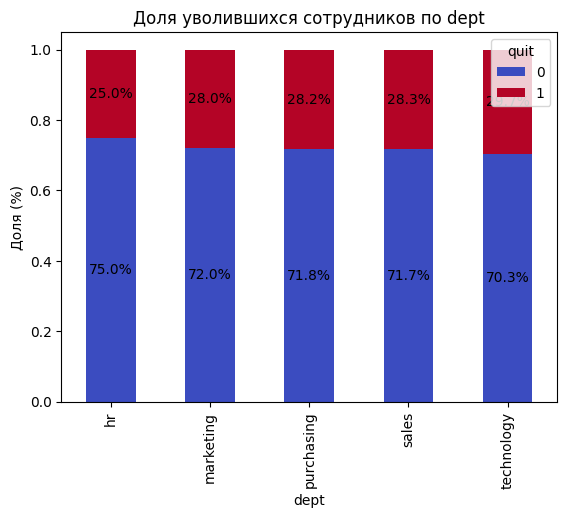

<Figure size 1000x600 with 0 Axes>

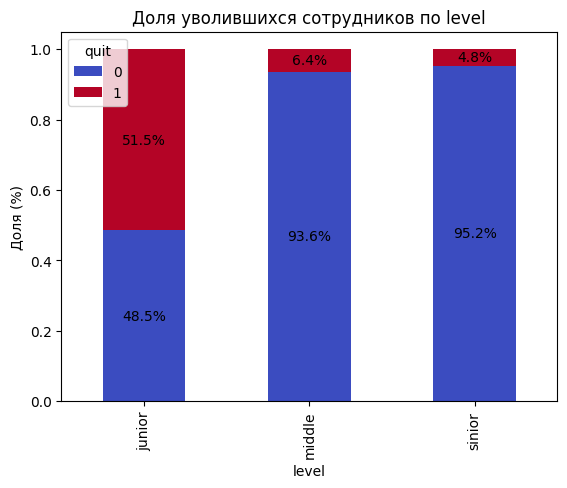

<Figure size 1000x600 with 0 Axes>

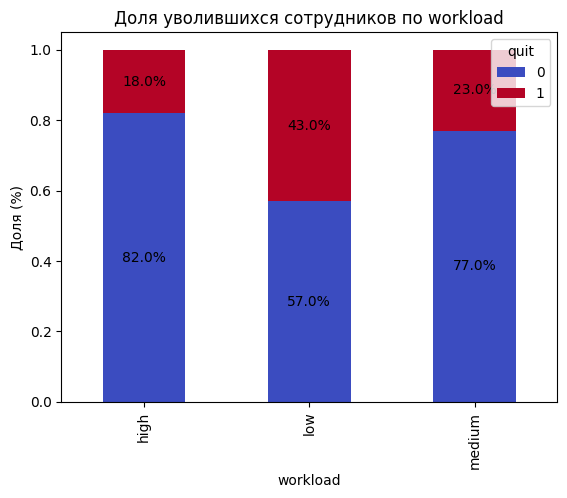

<Figure size 1000x600 with 0 Axes>

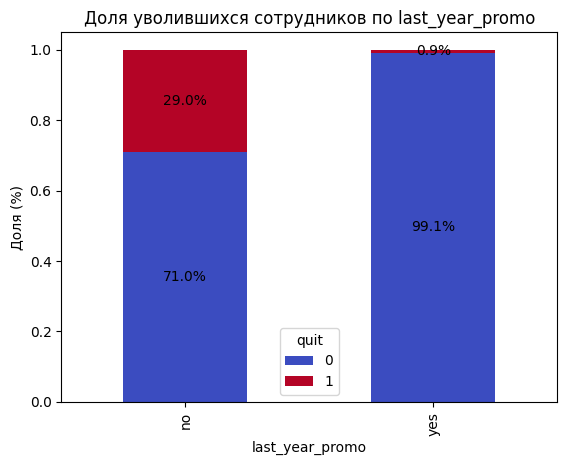

<Figure size 1000x600 with 0 Axes>

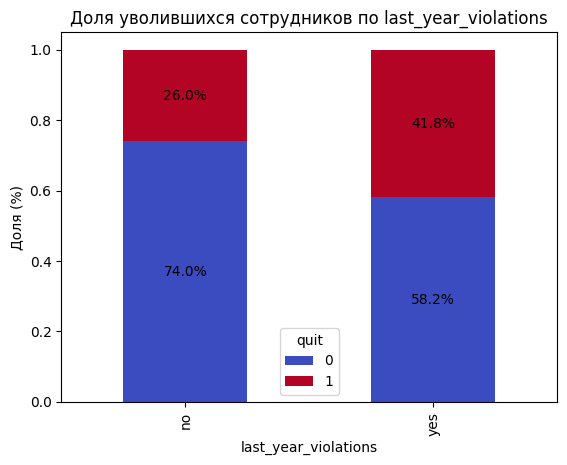

In [53]:

cat_col=train_quit_df.select_dtypes(include=['object']).columns.to_list()
for c_col in cat_col:
    plt.figure(figsize=(10, 6))
    quit_cat = train_quit_df.groupby(str(c_col))['quit'].value_counts(normalize=True).unstack()
    ax = quit_cat.plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title(f'Доля уволившихся сотрудников по {c_col}')
    plt.ylabel('Доля (%)')
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2, p.get_y() + height / 2, f'{height * 100:.1f}%', ha='center', va='center')
    plt.show()

<b>Вывод</b>

- Часто уволняется сотрудники с опытом менее 2-х лет.
- Если ежемесячная зарплата сотрудника в диапазоне 10-20 тысяч то он часто уволится.
- В основном уволняется сотрудники  джуниор .
- Сотрудники  отделе sales и technology уволняется чаще чем других отделов.
- Сотрудники который не получили повышения или нарушиили больше в прошлом году тоже часто уволняется.
- Если у сотрудника загруженность меньше это увеличивает вероятность ухода.


### 3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [54]:
target_full_df=pd.merge(test_full_quit_df,test_target_df,on='id',how='left')

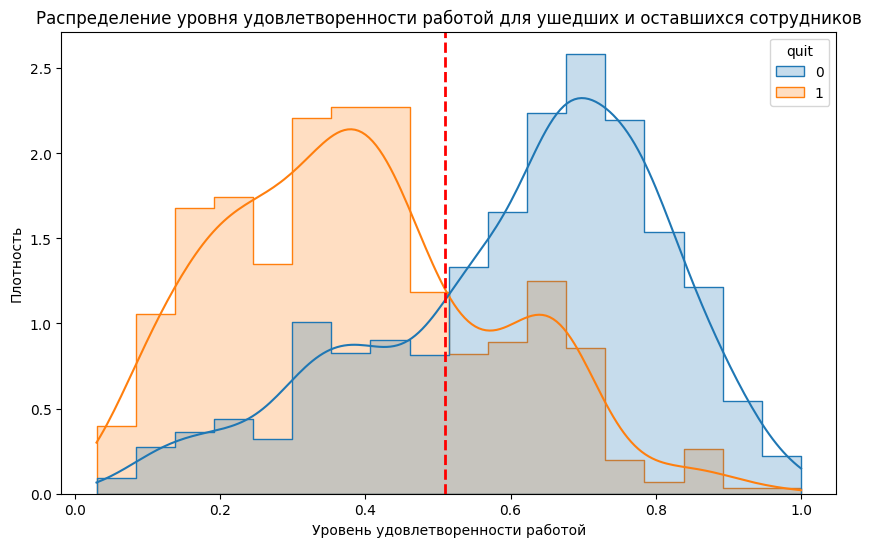

In [55]:
plt.figure(figsize=(10, 6))

sns.histplot(data=target_full_df, x='job_satisfaction_rate', hue='quit', kde=True, element='step', stat='density', common_norm=False) 
plt.axvline(0.51, color='red', linestyle='--', linewidth=2)
plt.title('Распределение уровня удовлетворенности работой для ушедших и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Плотность')
plt.show()

<b>Вывод</b>

- Аналитики правильно говорить при пороге уровня удовлетворенности работой менее 0.51 увеличивается количество уход сотрудников.
- Это говорить о связке между целевыми признаками.


## Шаг 4. Добавление нового входного признака

### Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [56]:
#Удалим полные дубликаты перед подоготовка

# train_quit_df.drop_duplicates(train_quit_df.drop('id', axis=1).columns,keep='first',inplace=True)

In [57]:
X=train_quit_df.drop(['id','quit'],axis=1)
train_quit_df['job_satisfaction_rate']=randomized_search.predict(X)

In [58]:
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,0,0.653109
1,814010,sales,junior,medium,2,no,no,4,27600,0,0.831589
2,155091,purchasing,middle,medium,5,no,no,1,37200,0,0.339246
3,257132,sales,junior,medium,2,no,yes,3,24000,1,0.343238
4,910140,marketing,junior,medium,2,no,no,5,25200,0,0.708216


In [59]:
train_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   int32  
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 328.3+ KB


In [60]:
X_test_quit=test_full_quit_df.drop(['id','quit'],axis=1)
test_full_quit_df['job_satisfaction_rate']=randomized_search.predict(X_test_quit)

In [61]:
test_full_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   quit                   2000 non-null   int32  
 10  job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 164.2+ KB


<b>Вывод</b>

- Выполнили задания.

## Шаг 5. Подготовка данных

### Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки. При кодировании учитывайте особенности  признаков и моделей и используйте как минимум два кодировщика.

In [62]:
train_quit_df.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit', 'job_satisfaction_rate'],
      dtype='object')

In [63]:
X_train=train_quit_df.drop(['id','quit'], axis=1)
y_train=train_quit_df['quit']



ohe_columns = ['dept','last_year_promo', 'last_year_violations']
ord_columns = ['workload','level']
num_columns = ['employment_years','supervisor_evaluation','salary','job_satisfaction_rate']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

## Шаг 6. Обучение моделей

### Обучите как минимум три модели. Подберите гиперпараметры как минимум для двух моделей. Проверьте качество лучшей модели.

In [64]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 200),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    # словарь для модели CatBoostClassifier
    {
        'models': [catboost.CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__iterations': range(100, 1000),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Learning rate set to 0.043343
0:	learn: 0.6608163	total: 4.23ms	remaining: 1.68s
1:	learn: 0.6281513	total: 7.46ms	remaining: 1.48s
2:	learn: 0.5993308	total: 10.7ms	remaining: 1.41s
3:	learn: 0.5737253	total: 13.7ms	remaining: 1.35s
4:	learn: 0.5504347	total: 16.9ms	remaining: 1.33s
5:	learn: 0.5313923	total: 20.2ms	remaining: 1.32s
6:	learn: 0.5127272	total: 23ms	remaining: 1.28s
7:	learn: 0.4958054	total: 25.8ms	remaining: 1.26s
8:	learn: 0.4851226	total: 29.2ms	remaining: 1.26s
9:	learn: 0.4717476	total: 33.1ms	remaining: 1.28s
10:	learn: 0.4597810	total: 36.1ms	remaining: 1.27s
11:	learn: 0.4477715	total: 38.9ms	remaining: 1.25s
12:	learn: 0.4399860	total: 41.8ms	remaining: 1.24s
13:	learn: 0.4295388	total: 44.5ms	remaining: 1.22s
14:	learn: 0.4234661	total: 47.6ms	remaining: 1.21s
15:	learn: 0.4146588	total: 50.8ms	remaining: 1.21s
16:	learn: 0.4063046	total: 53.8ms	remaining: 1.21s
17:	learn: 0.3987883	total: 57.5ms	remaining: 1.21s
18:	learn: 0.3923594	total: 61.2ms	remaining: 

In [65]:
# Получаем топ-10 лучших моделей, для анализа
pd.set_option('display.max_colwidth', None)
rs_quit_top_10 = pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score', ascending=True).head(10)
rs_quit_top_10[['param_models','params','mean_test_score','rank_test_score']]

,param_models,params,mean_test_score,rank_test_score
2,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 2, 'models__iterations': 398, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.942064,1
1,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 9, 'models__iterations': 114, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.940420,2
6,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 5, 'models__iterations': 766, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.940375,3
4,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': MinMaxScaler(), 'models__max_depth': 6, 'models__iterations': 385, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.939541,4
0,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 6, 'models__iterations': 515, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.939354,5
7,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 6, 'models__iterations': 419, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.939308,6
8,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': MinMaxScaler(), 'models__max_depth': 7, 'models__iterations': 452, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.939302,7
3,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 8, 'models__iterations': 899, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.938331,8
5,<catboost.core.CatBoostClassifier object at 0x000002FA8613A050>,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 9, 'models__iterations': 808, 'models': <catboost.core.CatBoostClassifier object at 0x000002FA8613A050>}",0.937542,9
9,KNeighborsClassifier(),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 131, 'models': KNeighborsClassifier()}",0.928363,10


In [66]:
X_test=test_full_quit_df.drop(['id','quit'],axis=1)
y_test=test_full_quit_df['quit']
y_pred_proba = randomized_search.predict_proba(X_test)
y_pred_proba_one = y_pred_proba[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, y_pred_proba_one))


Площадь ROC-кривой: 0.9338816699263124


In [67]:
print('Лучшая модель и её параметры:',randomized_search.best_estimator_.named_steps['models'].get_params())

Лучшая модель и её параметры: {'random_state': 42, 'max_depth': 2, 'iterations': 398}


<b>Вывод</b>

- Критерий успеха выполнено roc_auc_score=0.93 > 0.91.


## Шаг 7. Выводы

### Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.

<b>Вывод</b>

- Лучшая модель CatBoostClassifier с параметрамы {'random_state': 42, 'max_depth': 2, 'iterations': 398} метрика на тесте roc_auc_score=0.93.

- CatBoostClassifier устойчива к переобучению.

- CatBoost использует продвинутые методы градиентного бустинга, такие как алгоритм построения деревьев с симметричной структурой и оптимизация градиентов, что делает его более точным и эффективным в сравнении с другими бустинг-методами.


## Общий вывод

### Сформулируйте общий вывод:

  - опишите задачу;

  - опишите все этапы работы;
  
  - добавьте выводы и дополнительные предложения для бизнеса.

- Разработали модель машинного обучения, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика и предсказать то, что сотрудник уволится из компании.

- Провели предобработку данных: удалили полные дубликаты, проверили соответствия данных.

- В исследователский анализ данных: составили портрет уволившегося сотрудника, выявили связь между признака уровень удовлетворённости сотрудника и увольнение сотрудника из компании.

- Подготовили данных: использовали пайплайн ColumnTransformer два кодировку OneHotEncoder и OrdinalEncoder, масштабировали с StandardScaler и MinMaxScaler.

- Для поиска лучшего моделя для первого задания  использовали пайплан с гиперпараметрами модели RandomForestRegressor(), DecisionTreeRegressor(), LinearRegression() и  CatBoostRegressor() и поиска лучшего параметра RandomizedSearchCV. Для этого задания лучший модель  CatBoostRegressor с параметрамы {'loss_function': 'RMSE', 'random_state': 42, 'max_depth': 9, 'iterations': 302}  метрика на тесте smape=10.6.

- Для поиска лучшего моделя для второго  задания  использовали пайплан с гиперпараметрами модели RandomForestClassifier(), DecisionTreeClassifier(), LogisticRegression() и  CatBoostClassifier() и поиска лучшего параметра RandomizedSearchCV. Для этого задания лучший модель  CatBoostClassifier с параметрамы {'random_state': 42, 'max_depth': 2, 'iterations': 398} метрика на тесте roc_auc_score=0.93.

- Использование таких моделей позволит бизнесу не только прогнозировать уровень удовлетворенности сотрудников и вероятность их увольнения, но и активно работать над улучшением рабочей среды и удержанием ключевых сотрудников. 


Рекомендую на основе анализа портрета и модели:
  - Улучшение адаптации новых сотрудников.
  - Пересмотр структуры зарплат.
  - Поддержка и развитие джуниоров.
  - Улучшение условий в отделах Sales и Technology.
  - Программы поощрения и повышения.
  - Увеличение рабочей нагрузки и интересных задач.